# Introduction

Few month ago I discovered a phenomenon quite strange of graphs thanks to <a href="https://www.youtube.com/watch?v=MySkCFFgiRQ">this video</a> of Michael Launay explaining that usually, if you compare yourself to your friend you will have the impression that in average you have less friends than your friend. I found a small dataset were we will be able to check that. It's a dataset about social Network which is perfect in that case (<a href="https://snap.stanford.edu/data/egonets-Facebook.html">link</a>). In addition, this will also make me use a bit networkx I discovered recently on Datacamp.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

# Graphe creation

The dataset contain only a list of edges with anonymised facebook user. Let's load it.

In [2]:
G = nx.read_edgelist("F:/data/facebook_combined.txt", create_using=nx.Graph())

In [3]:
print("The graph has {} nodes and {} edges".format(len(G.nodes()), len(G.edges())))

The graph has 4039 nodes and 88234 edges


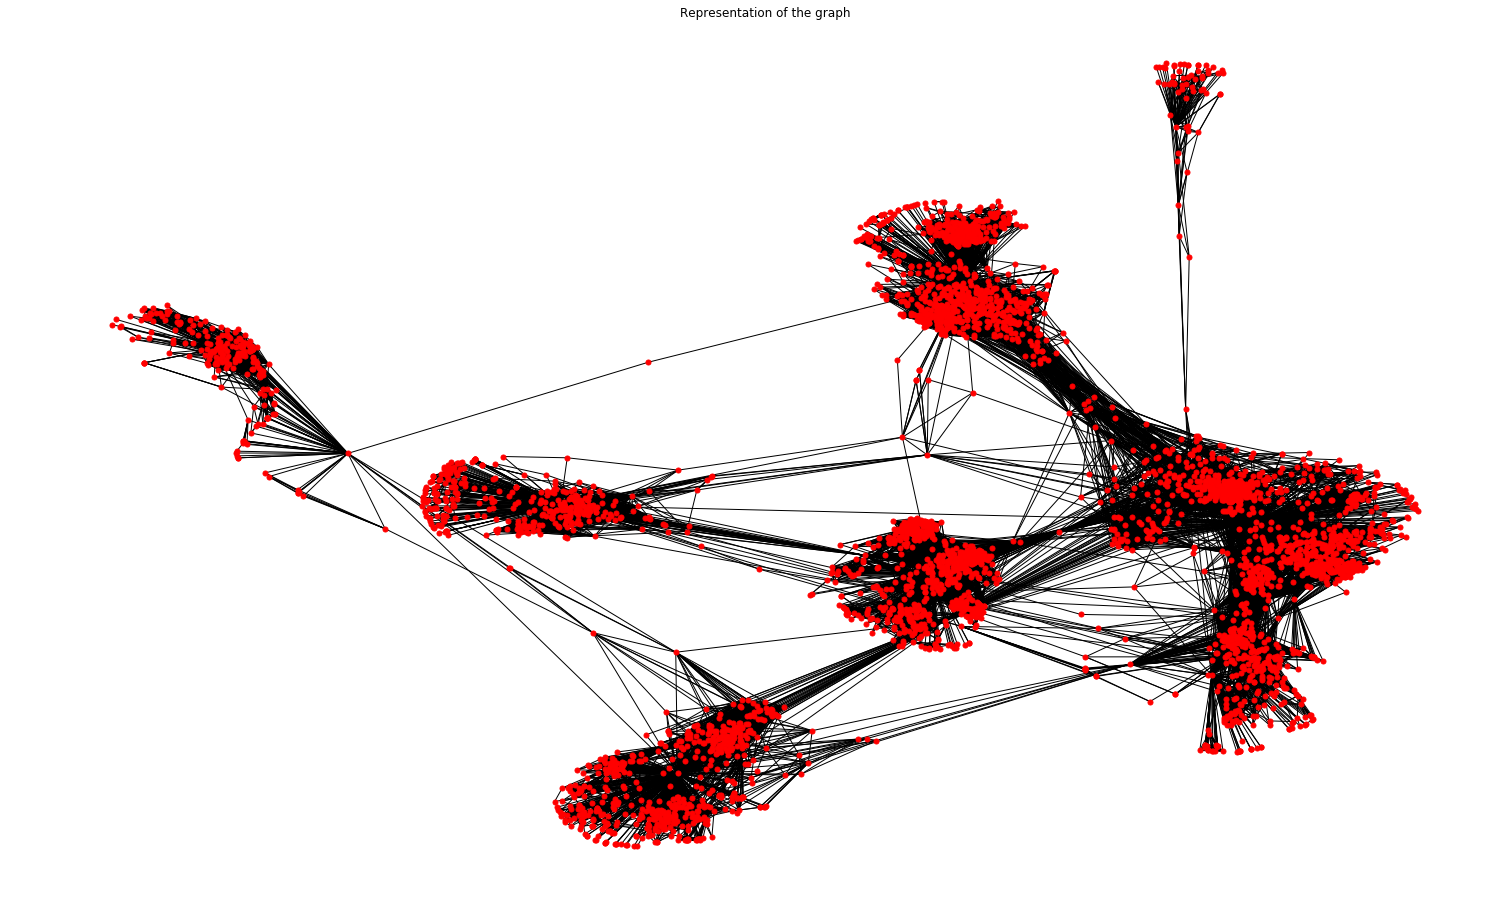

In [4]:
plt.figure(figsize=(20, 12))
nx.draw(G, with_labels=False, node_size=25)
plt.title("Representation of the graph")
plt.show()

# Creation of metrics

A nice metric to get is the average number of friends on this dataset. This value is unknown from users. At the same time, it would be great to save the number of friend for each node.

In [5]:
attr = {node : {"N" : len(G[node])} for node in G.nodes()} 
nx.set_node_attributes(G, attr)

In [6]:
# global_avg = sum([v["N"] for k, v in attr.items()]) / len(attr)
global_avg = len(G.edges()) / len(G.nodes())
print("In average, every node have {:.1f} friends".format(global_avg))

In average, every node have 21.8 friends


In [7]:
# sum([v["N"] for k, v in attr.items()])

Now we can also compute for every nodes 2 booleans:
- one if the nodes has more neighbors than the average of his neighbors
- one if the user has more neighbors than the average number of neighbors in the graph

In [8]:
me_lower_avg = []
me_lower_friend = []
attr2 = {} 

for node in G.nodes():
    me_number = G.nodes[node]["N"]
    friend_list = [G.nodes[neighbor]["N"] for neighbor in G.neighbors(node)]
    friends_avg = sum(friend_list) / len(friend_list)
    if friends_avg > me_number:
        me_lower_friend.append(1)
        v1 = 1
    else:
        me_lower_friend.append(0)
        v1 = 0
        
    if global_avg > me_number:
        me_lower_avg.append(0)
        v2 = 0
    else: 
        me_lower_avg.append(1)
        v2 = 1
        
    attr2[node] = {"friends_above_me" : v1, "avg_above_me" : v2}
    
nx.set_node_attributes(G, attr2)

Now we can have a look at both metrics. According Mickael Launay, we should have the feeling that we have less friends than our friends. If it's true, the value should be above the average.

In [9]:
print("On {} nodes, {} have their neighbors with an higher average than themself". format(len(G.nodes()), sum(me_lower_friend)))

On 4039 nodes, 3533 have their neighbors with an higher average than themself


Now let's look at the metric about the number of friends vs the complete network

In [10]:
print("On {} nodes, {} have less neighbors than the average of the network".format(len(G.nodes()), sum(me_lower_avg)))

On 4039 nodes, 2226 have less neighbors than the average of the network


This impression is true and Mickael Launay explain it quite simply. Let's try to see that on a sub graph. To do so, we will use 1 point, and 2 level of neighbors. I wanted to keep only 1 subgraph by removing a node which is kind of a bridge. However, this requires to compute the betweenness centrality which is very slow as it required to compute the shortest path between each pair of points ((in our case 4039 * 4038 paths)

In [11]:
# nx.betweenness_centrality(G)

I've chosen the node 10 because it doesn't have a lot of neightbors and the subgraph will not explode too much

In [12]:
# for k, v in attr.items():
#     print(k, v["N"])

We can now find all the node we will keep with a 2 level BFS

In [13]:
selected_node = "10"
sub_nodes = [selected_node] + [node for node in G.neighbors(selected_node)]
queue = [node for node in G.neighbors(selected_node)]

for each in queue:
    sub_nodes += [node for node in G.neighbors(each)]

Let's remove duplicates and create the subgraph

In [14]:
sub_nodes = set(sub_nodes)

In [15]:
H = G.subgraph(sub_nodes).copy()

In [16]:
print("The graph has {} nodes and {} edges".format(len(H.nodes()), len(H.edges())))

The graph has 348 nodes and 2866 edges


Now the graph is smaller but we have to keep in mind that some nodes (2nd level) wont's have all their neighbors visible. Now, we will render the graph with different color.
- A red node means that it meets the condition in the title
- A blue node means that the condition in the title is not met

In [17]:
mapping = ["b", "r"]
colors1 = []
colors2 = []
for n in H.nodes():
    a = H.node[n]['avg_above_me']
    b = H.node[n]['friends_above_me']
    colors1.append(mapping[a])
    colors2.append(mapping[b])

Let's compute nodes position once for all the graph to ease understanding

In [18]:
pos = nx.spring_layout(H)

Now let's plot a first graph with the node color based on the number of neighbors of each nodes. <b>The bigger dot is the stating point</b>

In [19]:
n_neighbor_list = [math.log(H.node[n]["N"]) for n in H.nodes()]
sizes = [25 if node != selected_node else 200 for node in H.nodes()]

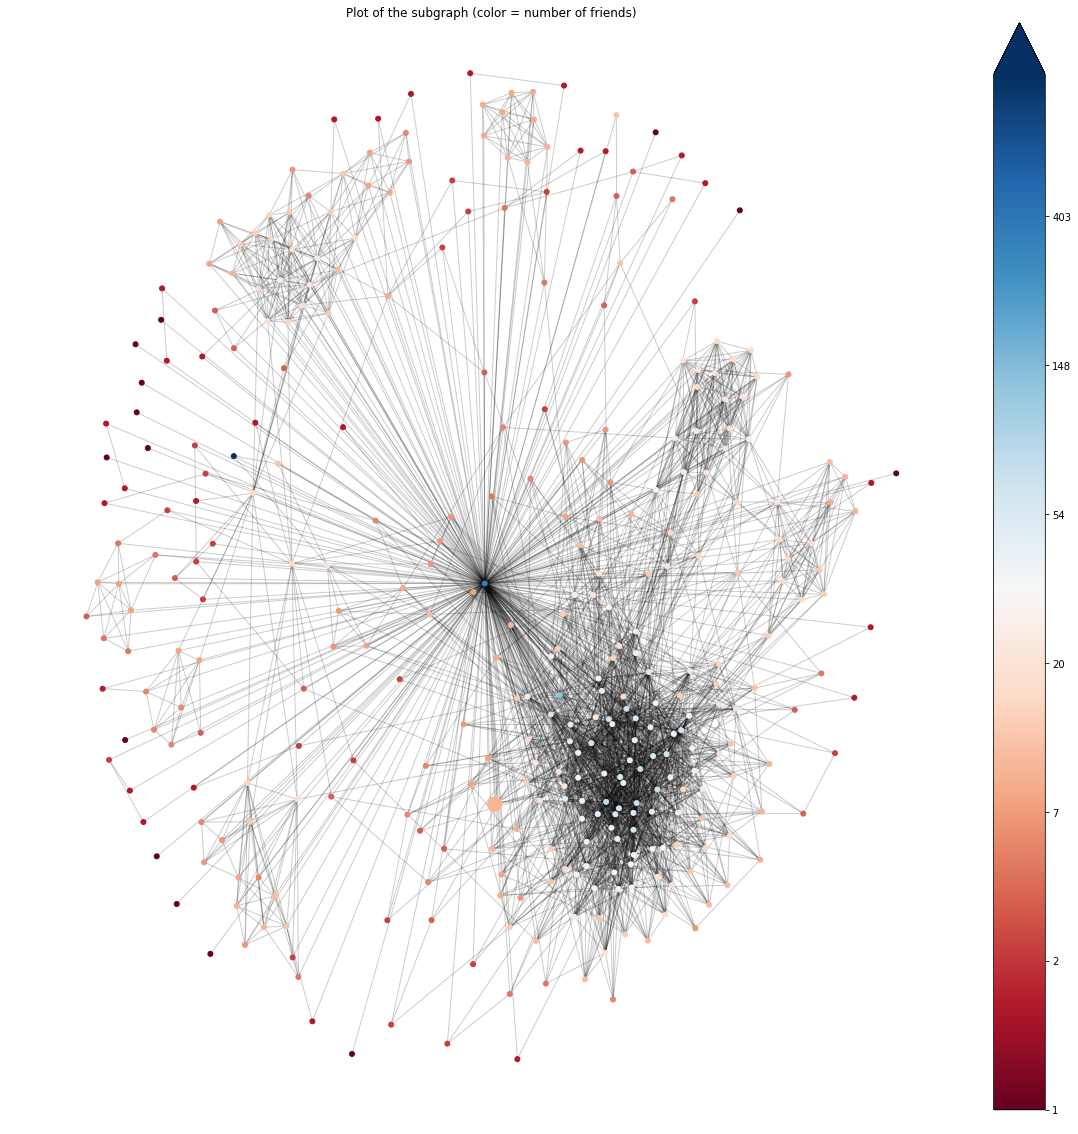

In [20]:
fig, ax = plt.subplots(figsize=(20, 20))

ec = nx.draw_networkx_edges(H, pos, alpha=0.2, ax=ax)
nc = nx.draw_networkx_nodes(H, pos, nodelist=H.nodes(), node_color=n_neighbor_list, 
                            with_labels=False, node_size=sizes, ax=ax, cmap="RdBu")
ax.axis('off')
ax.set_title("Plot of the subgraph (color = number of friends)")

cbar = fig.colorbar(nc, ax=ax, extend='max')
cbar.ax.set_yticklabels([int(math.exp(float(x.get_text()))) for x in cbar.ax.get_yticklabels()])
plt.show()

Now we can have a look at the 2 metrics previously created

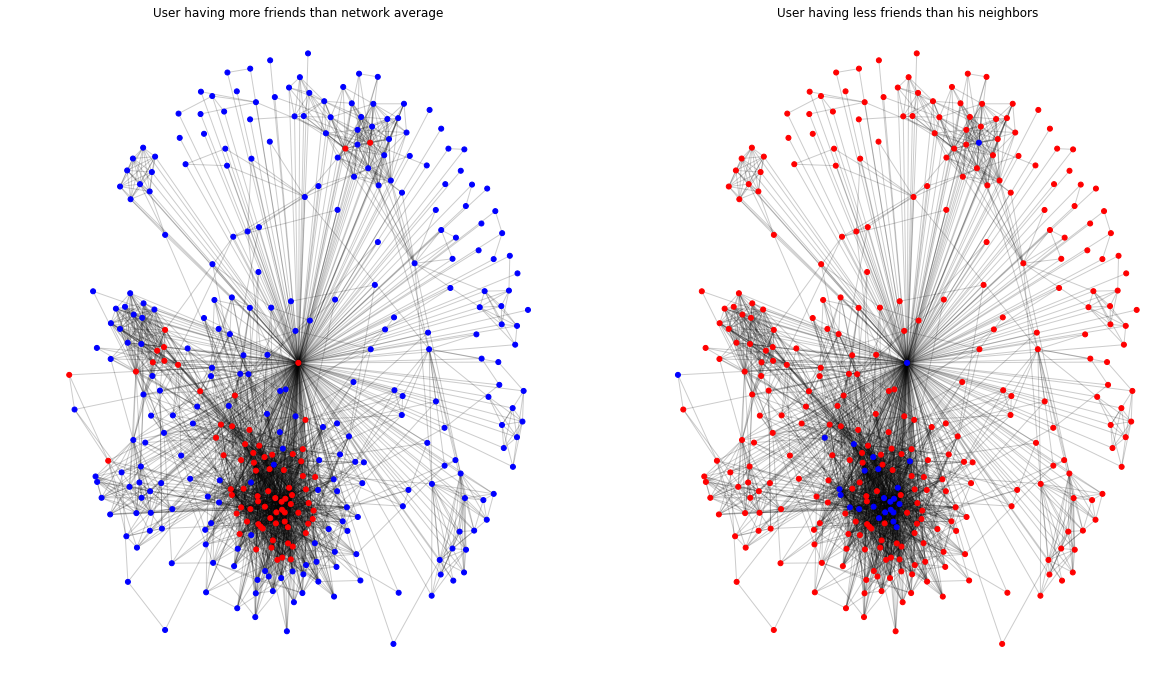

In [21]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 12))
pos = nx.spring_layout(H)

ec = nx.draw_networkx_edges(H, pos, alpha=0.2, ax=ax)
nc = nx.draw_networkx_nodes(H, pos, nodelist=H.nodes(), node_color=colors1, 
                            with_labels=False, node_size=25, ax=ax)
ax.axis('off')
ax.set_title("User having more friends than network average")

ec = nx.draw_networkx_edges(H, pos, alpha=0.2, ax=ax2)
nc = nx.draw_networkx_nodes(H, pos, nodelist=H.nodes(), node_color=colors2, 
                            with_labels=False, node_size=25, ax=ax2)
ax2.axis('off')
ax2.set_title("User having less friends than his neighbors")

plt.show()

We can see that the nodes having more friends than the network average are often the one with more friends than his neighboring. However, we can see the phenomenon explained previously, where a vast number of persons have less friends than their neighbors, is true. Tt's basically due to the important number of edges connected to a few number of nodes. If we generate a clique, there is nothing like that. they all have the same number of friends and equal to the network average. 

# Conclusion

In this Notebook, I just wanted to check a phenomenon presented by Mickela Launay. On this simple dataset, we can see that this feeling is true and mainly due to unbalanced of friends in the network.